# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de confusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [416]:
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler 
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay

In [417]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [418]:
# données (features/ attributes of dataset )
#getting data from the data.csv file , data is int , and the delimiter is a coma 
#save the data in an array X 
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)

#shape function returns the number of columns and rows of the specified array 
print(X.shape)#just to see 

#reading the data into a 2 dimentional labeled data structure 
df = pd.read_csv("data.csv")

#prints a small summary of the df data 
df.info()
print(df)#just to see 

(5000, 400)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Columns: 400 entries, 13 to 13.220
dtypes: int64(400)
memory usage: 15.3 MB
      13  13.1  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  ...  13.211  \
0     14    14    14    14    14    14    14    14    14    14  ...      14   
1     16    16    16    16    16    16    16    16    16    16  ...      16   
2     12    12    12    12    12    12    12    12    12    12  ...      12   
3     13    13    13    13    13    13    13    13    13    13  ...      13   
4     11    11    11    11    11    11    11    11    11    11  ...      11   
...   ..   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
4994  12    12    12    12    12    12    12    12    12    12  ...      12   
4995  13    13    13    13    13    13    13    13    13    13  ...      13   
4996  15    15    15    15    15    15    15    15    15    15  ...      15   
4997  17    17    17    17    17    17    17    

In [419]:
# étiquettes (target)
#getting the data and store in Y 
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)

#the shape of the array Y 
Y.shape

#getting the data into  structured 2D labels 
df1 = pd.read_csv("labels.csv")

#column 10 of the dataframe and value_counts() returns the series of unique values 
#using this line of code to check our data set and see if it balanced for the training 
df1["10"].value_counts()

10
1     500
2     500
3     500
4     500
5     500
6     500
7     500
8     500
9     500
10    499
Name: count, dtype: int64

Afficher aléatoirement quelques données de notre base

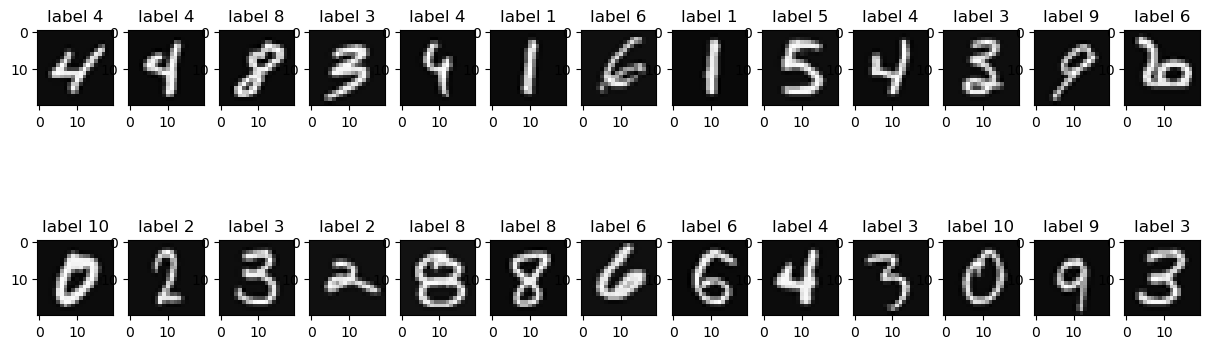

In [420]:
#figure:creates a new figure with a specific size using : figsiz(a,b) 
#sachant que a: represente la longueur du rectangle blanc ; b: represente l'espace entre deux subplot (LE JUSTIIIIIFYYYYY BEETWEEEEEEEEEEENE) 
plt.figure(figsize=(15,5)) 

#note: each 500 lines, there is a new value
for i in range(26):
    
    #pick a random line from the dataset between 0 ,rows of array X 
    c = random.randint(X.shape[0])
    
     #shape of one number in the image //////////////////// MATRICE X SACHANT QUE : [ROW,COL] ////// : JUSQU'A LA FIN EXEMPLE [1,:] DE 1 A LA FIN
    a = X[c,:].reshape((20, 20))
    
    # la transposé (rendre les ligne des colonne et vice versa) for better visualisation 
    a= np.transpose(a) 
    
    #creating subplots with 2 lines 13 columns 
    plt.subplot(2,13,i+1)
    
    #attributing label titles
    plt.title('label '+ str(Y[c]))
    
    #displaying with cmap='gray'
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Implementation des fonction suivantes , puis faire les appels de ces derniers pour chaque methode (knn ,Mvs, rn,...)  

- Matrice de confusion :

In [421]:
# matrice de confusion : permet d'avoir toutes les autres métriques (en utilisant les TP TN FP FN)
# parametres : set of predictions : result of training, set targets : Y

#implementation de cfonction qui genere la matrice de confusion 
def matrix_confusion(predict_set, target_set):
    
    #intit array of 10 columns 10 lines and specifying the data type 
    matrix = np.array([np.arange(10)]*10, dtype=np.int64)
    
    #filling the entire array with 0 
    matrix.fill(0)
    
    for y_p, y_t in zip(predict_set, target_set):
            matrix[y_t-1,y_p-1] += 1        
    return matrix


def measures_matrix(MC):
    #les mesures de matrices (TP , FP , FN ,TN ) pour chaque classes (0-9 ) 
    measures_matrix = pd.DataFrame(index=["TP", "FN", "FP", "TN"], columns=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
    
    #get the total numbers of an instance 
    total = np.sum(MC[0:np.shape(MC)[1], 0:np.shape(MC)[1]])
    
    for i in range(np.shape(MC)[0]):
        #calculating True positives 
        measures_matrix.loc["TP", str(i)] = MC[i][i]
        
        #calculation False positives 
        measures_matrix.loc["FP", str(i)] = np.sum(MC[:,i]) - measures_matrix.loc["TP", str(i)]
        
        #calculating false negatives 
        measures_matrix.loc["FN", str(i)] = np.sum(MC[i,:]) - measures_matrix.loc["TP", str(i)]
        
        #calculating true negatives 
        measures_matrix.loc["TN", str(i)] = total - (measures_matrix.loc["TP", str(i)] + measures_matrix.loc["FP", str(i)] + measures_matrix.loc["FN", str(i)])
            
    return measures_matrix

- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [422]:
#implementing the function to calculate the accuracy 
def Accuracy(measures_matrix):
    L = measures_matrix.shape[1]
    sumAcc = 0
    for i in range(L):
        sumAcc = sumAcc + (measures_matrix.loc["TP", str(i)] + measures_matrix.loc["TN", str(i)]) / (measures_matrix.loc["TP", str(i)] + measures_matrix.loc["TN", str(i)] + measures_matrix.loc["FP", str(i)] + measures_matrix.loc["FN", str(i)])
    return (sumAcc / L)    

- Recall (True Positive Rate) = TP/(TP + FN)

In [423]:
#implementing the function to calculate the Recall 
def Recall(measures_matrix):
    L = measures_matrix.shape[1]
    sumRecall = 0
    for i in range(L):
        sumRecall += (measures_matrix.loc["TP", str(i)]) / (measures_matrix.loc["TP", str(i)] + measures_matrix.loc["FN", str(i)])
    return ((1/L)*sumRecall)    

- Précision = TP/(TP + FP)

In [424]:
#implementing the function to calculate the Precision 
def Precision(measures_matrix):
    L = measures_matrix.shape[1]
    sumPrecision = 0
    for i in range(L):
        sumPrecision += (measures_matrix.loc["TP", str(i)]) / (measures_matrix.loc["TP", str(i)] + measures_matrix.loc["FP", str(i)])
    return ((1/L)*sumPrecision)  

- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [425]:
#function that returns the false positive rate 
def FP_rate(measures_matrix):
    L = measures_matrix.shape[1]
    sumFPrate = 0
    for i in range(L):
        sumFPrate += (measures_matrix.loc["FP", str(i)]) / (measures_matrix.loc["FP", str(i)] + measures_matrix.loc["TN", str(i)])
    return ((1/L)*sumFPrate)  

- Spécificité (True Negative Rate) = TN / (TN + FP)

In [426]:
#function that returns the specificity rate 
def Specificity(measures_matrix):
    L = measures_matrix.shape[1]
    sumSpecificity = 0
    for i in range(L):
        sumSpecificity += (measures_matrix.loc["TN", str(i)]) / (measures_matrix.loc["TN", str(i)] + measures_matrix.loc["FP", str(i)])
    return ((1/L)*sumSpecificity)  

- Courbe ROC

In [427]:
#this function takes the number of classes , the Y_test_set ,and the probability of predictions of the specific model 
def plot_roc_curve(num_classes, y_test, y_scores):
    #false positive rate list 
    fpr_list = []
    
    #true positive rate list 
    tpr_list = []
    
    #the ROC and AUC scores list 
    roc_auc_list = []

    #for all the classes 
    for i in range(num_classes):
        #the true label class is represented by 1 and the rest of the classes by 0 
        true_labels_i = (y_test == i).astype(int)
        
        #extract the probability score for class i 
        #sample_probs iterates over each dictionary in the y_scores list (each dictionary contains the proba predi for each class in the test set.
        #get(i,0.0) used to retrieve the probability prediction for class i from each dictionary.default 0 
        class_probs = np.array([sample_probs.get(i, 0.0) for sample_probs in y_scores]) 
        
        #storing the false positive rate and true positive rate for each thresholds 
        fpr_i = []
        tpr_i = []
        
        # sorted set of unique probability scores for class i in descending order.
        thresholds = sorted(set(class_probs), reverse=True)
        
        #loop all the thresholds of the class i 
        for threshold in thresholds:
            
            #obtaining binary predictions 
            #class_probs is an array containing the proba prediction of class i for each sample 
            #threshold scalar value that determines the boundary between positive and negative predictions. 
            #predicted labels i is an int  array each value is the result of the condition 
            #astype(int ) converting boolean result to int
            predicted_labels_i = (class_probs >= threshold).astype(int)
            
            #true possitive is the sum of true values 
            tp = np.sum((true_labels_i == 1) & (predicted_labels_i == 1))
            
            #false positive is the sum of false value but predicted true  
            fp = np.sum((true_labels_i == 0) & (predicted_labels_i == 1))
            
            #calculating the false positive rate and true positive rate 
            fpr = fp / np.sum(true_labels_i == 0) if np.sum(true_labels_i == 0) > 0 else 0
            tpr = tp / np.sum(true_labels_i == 1) if np.sum(true_labels_i == 1) > 0 else 0
            
            #adding the values of tpr and fpr using this threshold 
            fpr_i.append(fpr)
            tpr_i.append(tpr)

        #trapz takes the two arrays of x and y and returns the area (approximatly) under the  represented curve 
        roc_auc_i = np.trapz(tpr_i, fpr_i)
        
        #adding the fpr for all  thresholds of the class i 
        fpr_list.append(fpr_i)
        tpr_list.append(tpr_i)
        roc_auc_list.append(roc_auc_i)
    
    #displaying the ROC figure , curves of each class 
    #set the figure size 
    plt.figure(figsize=(6, 4))  
    
    #using the tpr and fpr arrays to draw the curves 
    for i in range(num_classes):
        plt.plot(fpr_list[i], tpr_list[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc_list[i]))

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
    
    #adjusting the y and x 
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves')

    plt.legend(loc="lower right", fontsize='small')  # Adjust legend font size

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with transparency

    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.show()

        
    




# Classification

Définir d'abord la base d'entrainement X_train_set, Y_train_set et la base de test X_test_set, Y_test_set

In [428]:
# DATA BETWEEN -1 AND 1 
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler() 
print(X[0])
# Compute the mean (moyenne) and std (norme) to be used for later scaling.
scaler.fit(X) 
 # on fait une normalisation, pour qu'aucun attribut n'influence l'entrainement /////// Perform standardization by centering and scaling.
scaled_features = scaler.transform(X)

print(scaled_features[0])

X_train_set, X_test_set, Y_train_set, Y_test_set = train_test_split(
      scaled_features, Y, test_size = 0.30) # tt = test, t = train

[ 13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  11   8
   8   8   8   9  12  13  13  13  13  13  13  13  13  13  13  13  10   6
  31  74  76  77  76  65  19  11  13  13  13  13  13  13  13  13  13  10
  32 101 211 244 237 228 244 235 116  11  12  13  13  13  13  13  13  12
   7  36 161 251 209 138  92  75 167 246 221  37   9  13  13  13  13  13
  12  15  54 196 236 120  29  12   3   1  49 221 255  48   8  13  13  13
  13  13   5  77 229 254 151  12   8  12  13  10  49 224 225  38   9  13
  13  13  13   7  43 193 250 187  78  14  12  13  13   4 117 251 137  12
  12  13  13  13  10  50 193 252 198  50  10  13  13  13  11  13 179 208
  48   8  13  13  13  11  21 173 250 247 216 103   9  13  13  12   6  98
 229 119   3  13  13  13  13   8  43 239 230 192 21

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

The confusion matrix of this model is
 


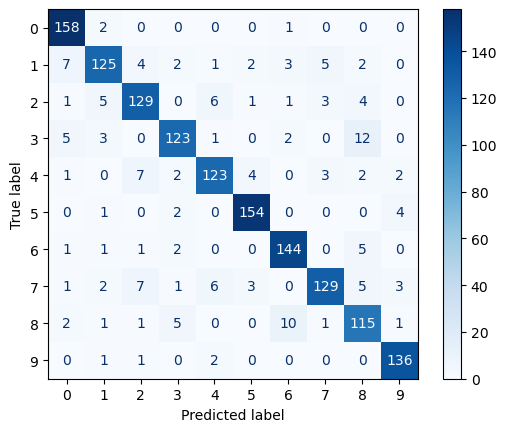


The accuracy of this model is 0.9781333333333333 


The recall of this model is 0.889607298112855 


The precision of this model is 0.8899892643475655 


The FP RATE of this model is 0.012137877551284258 


The specificity of this model is  0.9878621224487157 



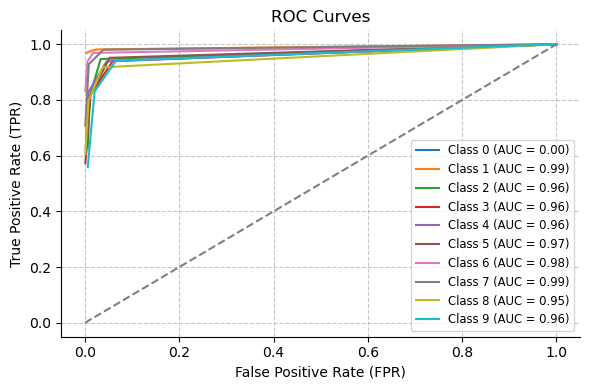

In [429]:
from sklearn.preprocessing import label_binarize
#regrouping all the function in onw class Knn 
class KNN:
    
    #this function initialises the parameters of the KNN method 
    #find the best value  for k !!!!!!!!!
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        
    #this function calculates the distance between two attributes 
    def euclidean_distance(self, x1, x2):
        distance = np.sqrt(np.sum((x1 - x2) ** 2))
        return distance
    
    #keep traces of the X,Y training values 
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    #this function uses a helper methode _predict 
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        
        #computing the distances 
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        
        #get the index of the closests 
        k_indices = np.argsort(distances)[:self.k]
        
        #get the labels of the closests 
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        #find the common one and return it 
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]
    
    #get the proba of predictions 
    def predict_proba(self, X):
        probabilities = []
        for x in X:
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            class_counts = Counter(k_nearest_labels)
            class_prob = {class_label: class_counts[class_label] / self.k for class_label in np.unique(self.y_train)}
            probabilities.append(class_prob)
        return probabilities


#Application 
#preparing the needed parameters for the methode knn 
knn_clf = KNN(k=3)
knn_clf.fit(X_train_set, Y_train_set)
prediction = knn_clf.predict(X_test_set)


#preparing the attributs to get the confusion matrix 
predictions = np.array(prediction)
#Y_test = np.array(Y_test_set)

#confusion matrix 
MC_knn = matrix_confusion(predict_set=predictions, target_set=Y_test_set)

#displaying the matrix 
print("The confusion matrix of this model is\n ")
cm_display = ConfusionMatrixDisplay(confusion_matrix = MC_knn)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# ACCURACY
Acc_knn = Accuracy(measures_matrix(MC_knn))
print("\nThe accuracy of this model is", Acc_knn, "\n")

# RECALL // SENSITIVITY
recall_knn = Recall(measures_matrix(MC_knn))
print("\nThe recall of this model is", recall_knn, "\n")

# PRECISION
precision_knn = Precision(measures_matrix(MC_knn))
print("\nThe precision of this model is", precision_knn, "\n")

# FP RATE
fP_rate_knn = FP_rate(measures_matrix(MC_knn))
print("\nThe FP RATE of this model is" , fP_rate_knn , "\n")

# SPECIFICITY
specificity_knn = Specificity(measures_matrix(MC_knn))
print("\nThe specificity of this model is " , specificity_knn, "\n")

#ROC 
probability_predictions = knn_clf.predict_proba(X_test_set)
plot_roc_curve(10, Y_test_set, probability_predictions)


# Méthode 1: MVS
Machine à Vecteurs de Support

The confusion matrix of this model is



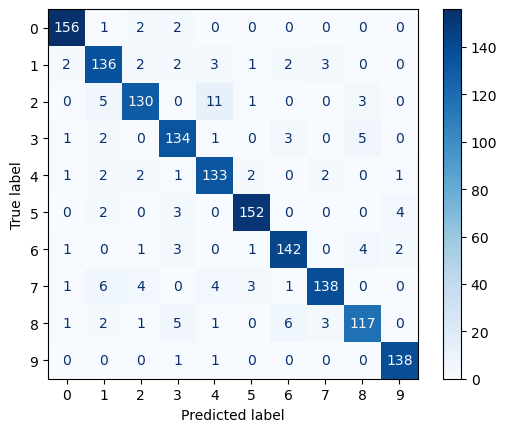


The accuracy of this model is 0.9834666666666667


The recall of this model is 0.9119882466427556


The precision of this model is 0.9171380910091745


The FP RATE of this model is 0.009177602320884985


The specificity of this model is 0.9908223976791151



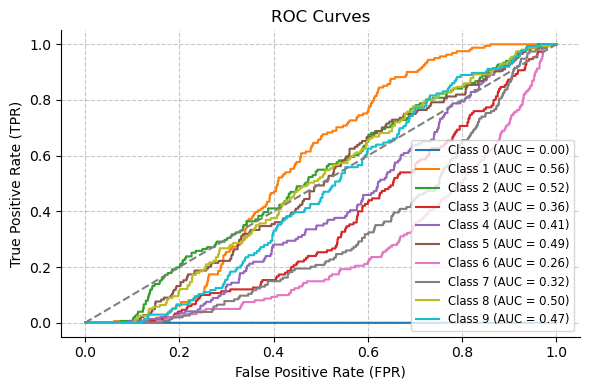

In [430]:
# Create the model with probability estimation enabled
model = svm.SVC(kernel='linear', probability=True)

# entrainement 
model.fit(X_train_set, Y_train_set)

# Prediction
y_pred = model.predict(X_test_set) 

# Probability estimates
y_prob = model.predict_proba(X_test_set)

# Confusion matrix
MC_mvs = matrix_confusion((y_pred), (Y_test_set))


#displaying 
print("The confusion matrix of this model is\n")
cm_display = ConfusionMatrixDisplay(confusion_matrix = MC_mvs)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()


# ACCURACY
accuracy_mvs = Accuracy(measures_matrix(MC=MC_mvs))
print("\nThe accuracy of this model is %s\n" % accuracy_mvs)


# RECALL // SENSITIVITY
recall_mvs = Recall(measures_matrix(MC=MC))
print("\nThe recall of this model is %s\n" % recall_mvs)

# PRECISION
precision_mvs = Precision(measures_matrix(MC=MC_mvs))
print("\nThe precision of this model is %s\n" % precision_mvs)

# FP RATE
fP_rate_mvs = FP_rate(measures_matrix(MC=MC_mvs))
print("\nThe FP RATE of this model is %s\n" % fP_rate_mvs)

# SPECIFICITY
specificity_mvs = Specificity(measures_matrix(MC=MC_mvs))
print("\nThe specificity of this model is %s\n" % specificity_mvs)

#ROC
# Probability estimates
y_prob = model.predict_proba(X_test_set)
# Convert y_prob to the desired format (list of dictionaries)
y_prob_list = [dict(zip(range(10), prob)) for prob in y_prob]

# Now call plot_roc_curve with y_prob_list
plot_roc_curve(10, Y_test_set, y_prob_list)

1


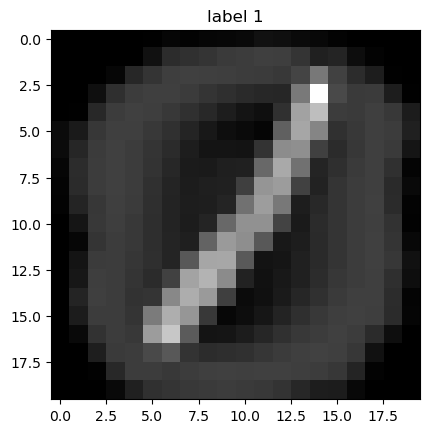

In [431]:
# tester une image

#generating  a random integer c between 0 and rows numbers  in the X_test_set array
c= random.randint(X_test_set.shape[0])

#printing the predected label for the random index 
print (y_pred[c])

#reshaping and transposing the image 
a = X_test_set[c,:].reshape((20, 20))
a= np.transpose(a)

#adding title 
plt.title('label '+ str(Y_test_set[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


The confusion matrix of this model is
 


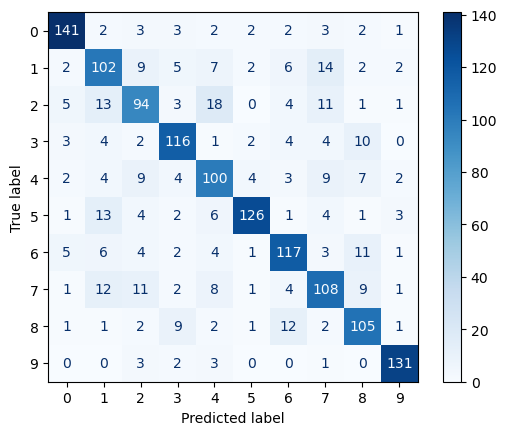


The accuracy of this model is 0.9520000000000002


The recall of this model is 0.7604924899121672


The precision of this model is 0.7614129393316608


The FP RATE of this model is 0.026654436482905514


The specificity of this model is 0.9733455635170944



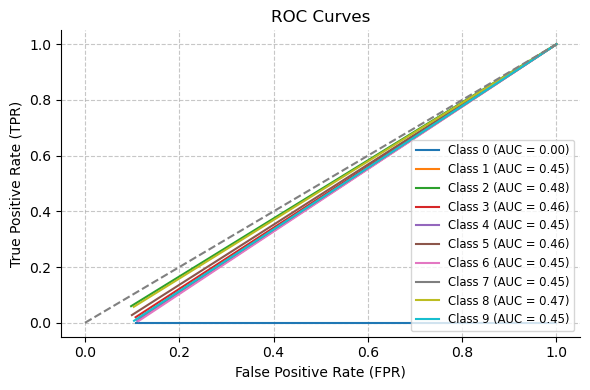

In [432]:
# Créer le modèle
model = DecisionTreeClassifier()

# Entrainer le modèle
model = model.fit(X_train_set, Y_train_set)

# Prediction
y_pred = model.predict(X_test_set)

# Confusion matrix
MC_abr = matrix_confusion((y_pred), (Y_test_set))

#displaying the matrix 
print("The confusion matrix of this model is\n " )
cm_display = ConfusionMatrixDisplay(confusion_matrix = MC_abr)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# ACCURACY
accuracy_abr = Accuracy(measures_matrix(MC=MC_abr))
print("\nThe accuracy of this model is %s\n" % accuracy_abr)


# RECALL // SENSITIVITY
recall_abr = Recall(measures_matrix(MC=MC_abr))
print("\nThe recall of this model is %s\n" % recall_abr)

# PRECISION
precision_abr = Precision(measures_matrix(MC=MC_abr))
print("\nThe precision of this model is %s\n" % precision_abr)

# FP RATE
fP_rate_abr  = FP_rate(measures_matrix(MC=MC_abr))
print("\nThe FP RATE of this model is %s\n" % fP_rate_abr)

# SPECIFICITY
specificity_abr = Specificity(measures_matrix(MC=MC_abr))
print("\nThe specificity of this model is %s\n" % specificity_abr)

# model.score(X_test_set, Y_test_set) # accuracy
y_prob = model.predict_proba(X_test_set)
# Convert y_prob to the desired format (list of dictionaries)
y_prob_list = [dict(zip(range(10), prob)) for prob in y_prob]

# Now call plot_roc_curve with y_prob_list
plot_roc_curve(10, Y_test_set, y_prob_list)


4


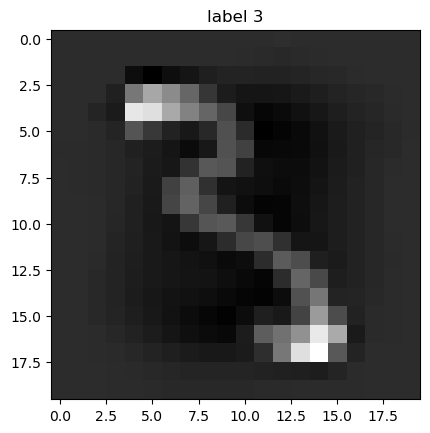

In [433]:
# same 
c= random.randint(X_test_set.shape[0])
print (y_pred[c])
a = X_test_set[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Y_test_set[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

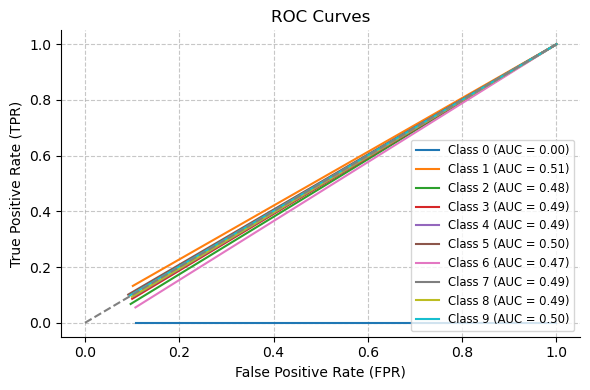

In [434]:
#creating  an instance of the Multi-layer Perceptron (MLP) classifier
#MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25), max_iter=100000)
#solver(sgb):  is the optimisation algorithm for training the neural networks 
#alpha(value):it helps preventing overfitting by adding this penalty 
#h_l_s: hidden layer with 25 neuros 
#max_iter: max number of iterations to train the neural network 
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)

#split the dataset into training and testing 
#X are the features , Y target 
X_train_set, X_test_set, Y_train_set, Y_test_set = train_test_split(X, Y, random_state=0, test_size=0.3)

#training the model 
model.fit(X_train_set, Y_train_set)

probability_predictions = model.predict_proba(X_test_set)
# Convert y_prob to the desired format (list of dictionaries)
probability_predictions_list = [dict(zip(range(10), prob)) for prob in y_prob]
# Now call plot_roc_curve with y_prob_list
plot_roc_curve(10, Y_test_set, probability_predictions_list)



In [435]:
# Choisir un image de test 
c=0
print(Y_test_set[c])

10


In [436]:
#predict  the results 
y_pred = model.predict([X_test_set[c,:]])
print(y_pred)

[10]


In [437]:
# pour ROC, il faudra les probabilités:
model.predict_proba([X_test_set[c,:]])

array([[0.10666979, 0.10150457, 0.09647699, 0.09782217, 0.09852038,
        0.09266769, 0.09081322, 0.10178223, 0.10360485, 0.11013812]])

Afficher l'image testée

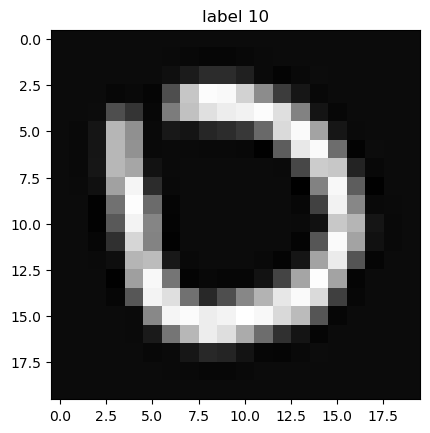

In [438]:
a = X_test_set[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Y_test_set[c]))
plt.imshow(a,cmap='gray')

# Compare between the performances of each methodes 
En utilisant les resultats metriques :

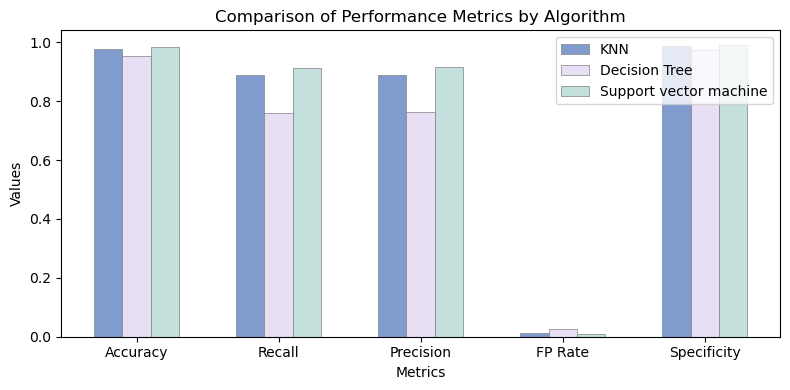

After this study we notice that the most suitable algorithm for our case (dataset) is the SVM method


In [439]:
metrics = ['Accuracy', 'Recall', 'Precision', 'FP Rate', 'Specificity']


# KNN metrics 
knn_metrics = [Acc_knn, recall_knn, precision_knn,fP_rate_knn, specificity_knn]

# Dtree metrics 
dtree_metrics = [accuracy_abr, recall_abr,precision_abr, fP_rate_abr, specificity_abr]

# Support vector machine metrics 
mvs_metrics = [accuracy_mvs, recall_mvs, precision_mvs, fP_rate_mvs, specificity_mvs]

# defining the position of each bar , same order 
positions = range(len(metrics))

# figure size of the graphical representation 
plt.figure(figsize=(8, 4))

#plt.bar parameters 
# defining the colors for each bar (methode )
knn_color = '#809bce'
dtree_color = '#e8dff5'
mvs_color = '#C3E0DD'

# the color of border of the bar 
border_color = 'grey'

# the width of each border  
border_width = 0.5

# the width of each bar 
bar_width = 0.20

index = range(len(metrics))


#adding the bars 
plt.bar([p - bar_width for p in index], knn_metrics, bar_width, label='KNN', color=knn_color, edgecolor=border_color,linewidth=border_width)
plt.bar(index, dtree_metrics, bar_width, label='Decision Tree', color=dtree_color, edgecolor=border_color,linewidth=border_width)
plt.bar([p + bar_width for p in index], mvs_metrics, bar_width, label='Support vector machine', color=mvs_color, edgecolor=border_color,linewidth=border_width)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Performance Metrics by Algorithm')


plt.xticks(index, metrics)
plt.legend()

plt.tight_layout()

plt.show()

print("After this study we notice that the most suitable algorithm for our case (dataset) is the SVM method")


# Comparing the ROC figures of the methods  


the best algorithm is the one with the max AUC score 
  
 
KNN ROC Figure  
 
 


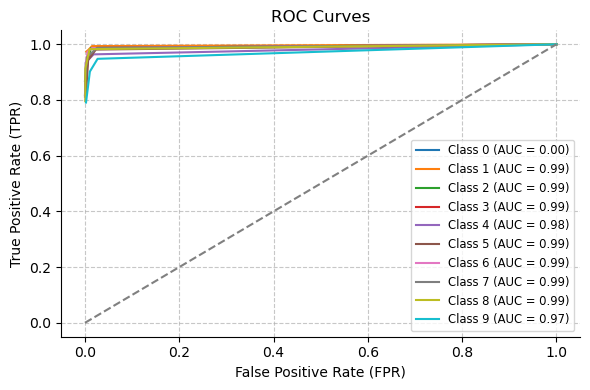


 
 
MVS ROC Figure  
 
 


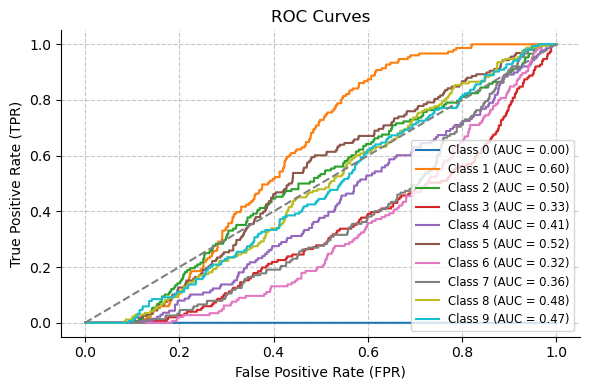


 
 
Dtree ROC Figure  
 
 


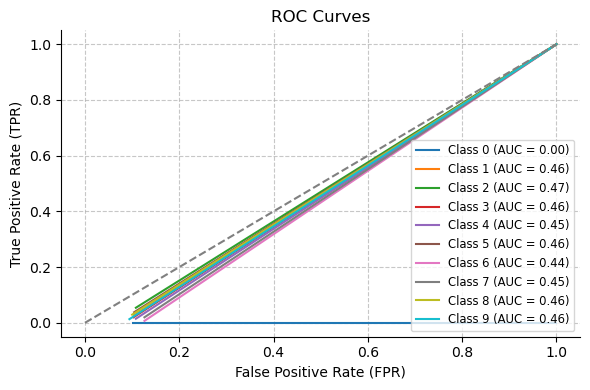


 
 
RN ROC Figure  
 
 


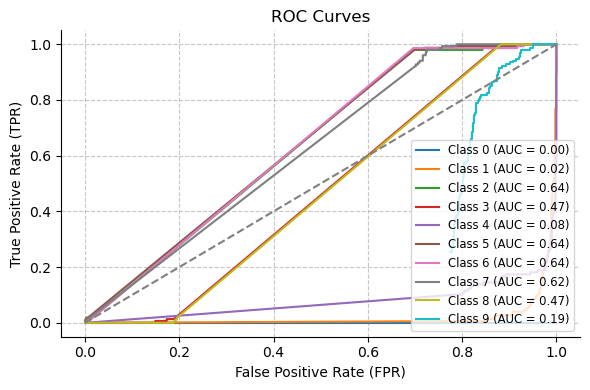

In [440]:



# Train and predict with KNN
knn_clf = KNN(k=3)
knn_clf.fit(X_train_set, Y_train_set)
probability_predictions_knn = knn_clf.predict_proba(X_test_set)

# Train and predict with SVM
svm_model = svm.SVC(kernel='linear', probability=True)
svm_model.fit(X_train_set, Y_train_set)
probability_predictions_svm = svm_model.predict_proba(X_test_set)

# Train and predict with Decision Tree
dtree_model = DecisionTreeClassifier()
dtree_model.fit(X_train_set, Y_train_set)
probability_predictions_dtree = dtree_model.predict_proba(X_test_set)

# Train and predict with MLP
mlp_model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25), max_iter=100000)
mlp_model.fit(X_train_set, Y_train_set)
probability_predictions_mlp = mlp_model.predict_proba(X_test_set)

# Convert y_prob to the desired format (list of dictionaries) when it is needed 
probability_predictions_list_svm = [dict(zip(range(10), prob)) for prob in probability_predictions_svm]
probability_predictions_list_dtree = [dict(zip(range(10), prob)) for prob in probability_predictions_dtree]
probability_predictions_list_mlp = [dict(zip(range(10), prob)) for prob in probability_predictions_mlp]

# Plot ROC curves for each algorithm
print("the best algorithm is the one with the max AUC score \n  \n ")
print("KNN ROC Figure  \n \n ")
plot_roc_curve(10, Y_test_set, probability_predictions_knn)
print("\n \n ")
print("MVS ROC Figure  \n \n ")
plot_roc_curve(10, Y_test_set, probability_predictions_list_svm)
print("\n \n ")
print("Dtree ROC Figure  \n \n ")
plot_roc_curve(10, Y_test_set, probability_predictions_list_dtree)
print("\n \n ")
print("RN ROC Figure  \n \n ")
plot_roc_curve(10, Y_test_set, probability_predictions_list_mlp)



